# Lab3: Clustering with K-means, K-means++ and Kmedioids

## Overview
In this lab, you will learn how to implement and analyze the **K-means**, **K-means++**  and **Kmedioids** clustering algorithms on two different real-world datasets:

- **MNIST Digits** (10 handwritten digits (image)).  
- **CIFAR-10 dataset** (different categories of imagenet style objects).  

You will compare the performance of **K-means**,  **K-means++** and **Kmedioids**.

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to anotehr value **you will not get full score**.


In [2]:
# Install dependencies if needed
!pip install datasets scikit-learn matplotlib numpy seaborn pandas
!pip install kmedoids

from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
import kmedoids
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
from collections import Counter
from sklearn.manifold import TSNE



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 32.1 MB/s eta 0:00:00


## Dataset MNIST (HandWritten Digits)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

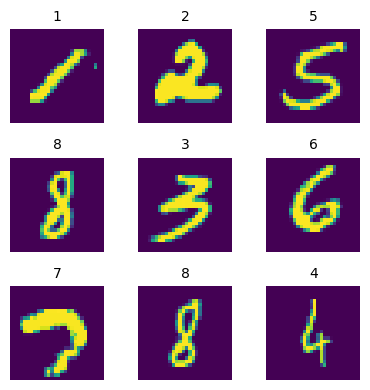

In [3]:
# 1. Load MNIST dataset

dataset = load_dataset("mnist", split="train[:5000]")
dataset = dataset.shuffle(seed=42)

fig, axes = plt.subplots(3, 3, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    img = dataset[i]["image"]
    label = dataset.features["label"].int2str(dataset[i]["label"])
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [4]:
# 2. Preprocess: resize + flatten images

X = np.array([np.array(img.resize((64, 64))).flatten()
              for img in dataset["image"]], dtype=np.float32)
X = X / 255.0  # normalize to [0, 1]

print("Data shape:", X.shape)  # (N, 64*64*3)


# Reduce to 50 dimensions (you can tune this number)
pca = PCA(n_components=786, random_state=42)
X = pca.fit_transform(X)


# 3. Extract labels

y = np.array(dataset["label"])
label_names = dataset.features["label"].names

print("Labels shape:", y.shape)

# 4. Count unique clusters

unique_labels, counts = np.unique(y, return_counts=True)
n_classes = len(unique_labels)

print("\nNumber of unique clusters (classes):", n_classes)
print("Allclasses:")
for i in range(n_classes):
    print(f"{unique_labels[i]} -> {label_names[unique_labels[i]]} ({counts[i]} samples)")


Data shape: (5000, 4096)
Labels shape: (5000,)

Number of unique clusters (classes): 10
Allclasses:
0 -> 0 (479 samples)
1 -> 1 (563 samples)
2 -> 2 (488 samples)
3 -> 3 (493 samples)
4 -> 4 (535 samples)
5 -> 5 (434 samples)
6 -> 6 (501 samples)
7 -> 7 (550 samples)
8 -> 8 (462 samples)
9 -> 9 (495 samples)


In [5]:
#This is a helper function that will help you visualize the top 5 datapoints in each cluster
def show_closest_images(X, dataset, centroids, labels, title, num_images=5):
    n_clusters = len(centroids)
    fig, axes = plt.subplots(n_clusters, num_images, figsize=(1.2*num_images, 1.2*n_clusters))


    # If only 1 cluster, fix axes shape
    if n_clusters == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, centroid in enumerate(centroids):
        distances = np.linalg.norm(X - centroid, axis=1)
        cluster_indices = np.where(labels == i)[0]

        if len(cluster_indices) == 0:
            continue

        closest_indices = cluster_indices[np.argsort(distances[cluster_indices])[:num_images]]

        for j, idx in enumerate(closest_indices):
            try:
                img = dataset[int(idx)]["image"]
            except:
                img = dataset[int(idx)]["img"]
            label_name = dataset.features["label"].int2str(dataset[int(idx)]["label"])

            axes[i, j].imshow(img)
            axes[i, j].axis("off")

            axes[i, j].text(0.5, -0.15, label_name,
                            size=7, ha="center", va="top", transform=axes[i, j].transAxes)

            if j == 0:
                axes[i, j].set_title(f"Cluster {i}", fontsize=9)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# [TODO] Implement KMeans for MNIST (2 points)

## Instructions

In this section, you will implement **K-means** using the **sklearn** library.

- Use the `KMeans` class from `sklearn.cluster`.
- Set the following parameters:
  - `n_clusters = k` (choose based on the dataset what do you think thge right number is for this dataset?).  
  - `init = "?"` what should this be for Kmeans?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).  

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to another value **you will not get full score**.

KMeans clustering completed.
Labels shape: (5000,)
Centroids shape: (10, 786)


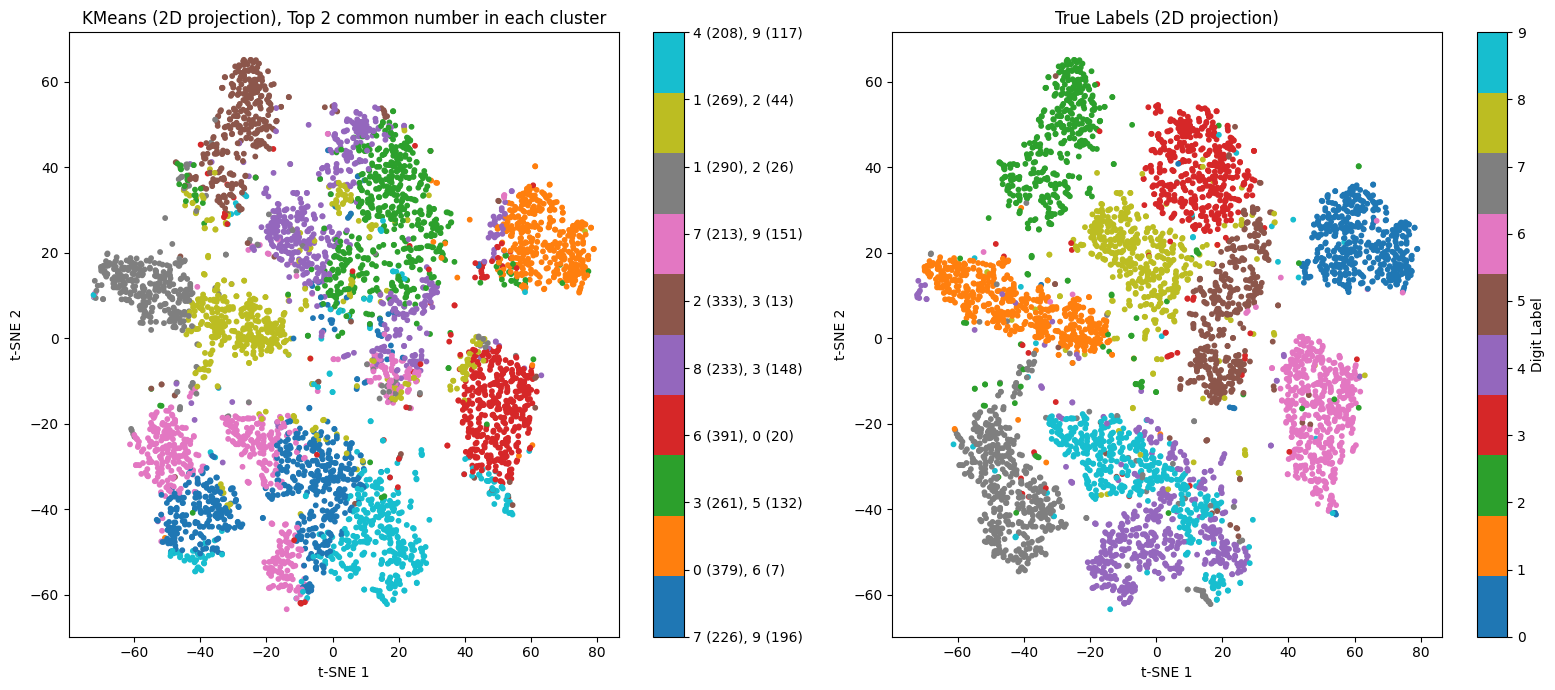

In [6]:
# ----------------------------
# TODO Implement KMeans
# ----------------------------

from sklearn.cluster import KMeans

# Number of clusters = 10 (digits 0-9 in MNIST)
k = 10

# Initialize and fit KMeans
kmeans = KMeans(
    n_clusters=k,
    init="k-means++",   # smart initialization
    n_init=10,          # run with 10 different centroid seeds
    max_iter=50,        # stop after 50 iterations
    random_state=42     # reproducibility
)

kmeans.fit(X)

# Get cluster labels for each data point
labels_km = kmeans.labels_

# Get centroids
centroids = kmeans.cluster_centers_

print("KMeans clustering completed.")
print("Labels shape:", labels_km.shape)
print("Centroids shape:", centroids.shape)


# ----------------------------
# Implemenetation ends here
# ----------------------------

# Reduce to 2D for visualization
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)


tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_km == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")


fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMeans clusters
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_km, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMeans (2D projection), Top 2 common number in each cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()




# [TODO]: Find Confused Digit Pairs in Kmeans (1 point)

- For each cluster, check the **second most common true label**.  
- If its count is **greater than 50**, record the pairs (most common, second most common) and write your answer here.

Answer: [TODO]


Cluster 0: Most=(np.int64(7), 226), Second=(np.int64(9), 196)
Cluster 2: Most=(np.int64(3), 261), Second=(np.int64(5), 132)
Cluster 4: Most=(np.int64(8), 233), Second=(np.int64(3), 148)
Cluster 6: Most=(np.int64(7), 213), Second=(np.int64(9), 151)
Cluster 9: Most=(np.int64(4), 208), Second=(np.int64(9), 117)

Confused digit pairs (most common, second most common):
[(np.int64(7), np.int64(9)), (np.int64(3), np.int64(5)), (np.int64(8), np.int64(3)), (np.int64(7), np.int64(9)), (np.int64(4), np.int64(9))]


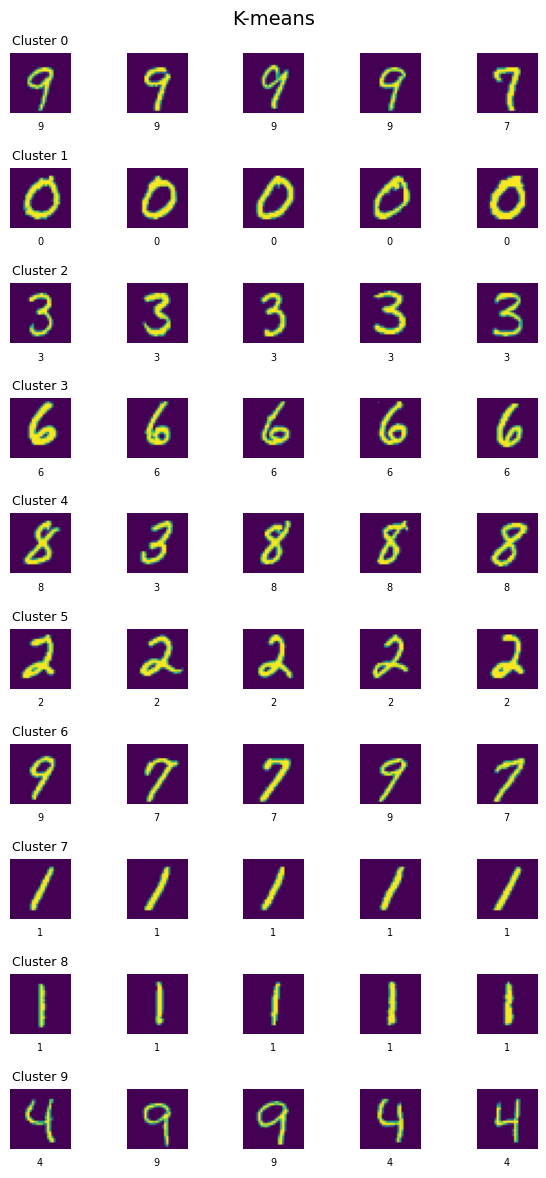

In [7]:
# Find Confused Digit Pairs in KMeans
from collections import Counter

confused_pairs = []

for cluster_id in range(k):
    idxs = np.where(labels_km == cluster_id)[0]
    true_labels = y[idxs]
    counts = Counter(true_labels).most_common()

    if len(counts) > 1:
        most_common, second_common = counts[0], counts[1]
        if second_common[1] > 50:
            confused_pairs.append((most_common[0], second_common[0]))
            print(f"Cluster {cluster_id}: Most={most_common}, Second={second_common}")

print("\nConfused digit pairs (most common, second most common):")
print(confused_pairs)

# Visualize clusters with example images
show_closest_images(X, dataset, centroids, labels_km, "K-means")


# [TODO] Implement KMeans++ for MNIST (2 points)

## Instructions

In this section, you will implement **K-means ++** using the **sklearn** library.

- Use the `KMeans` class from `sklearn.cluster`.
- Set the following parameters:
  - `n_clusters = k` (choose based on the dataset what do you think thge right number is for this dataset?).  
  - `init = "?"` what should this be for Kmeans ++ ?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).  

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to anotehr value **you will not get full score**.

KMeans++ clustering completed.
Labels shape: (5000,)
Centroids shape: (10, 786)


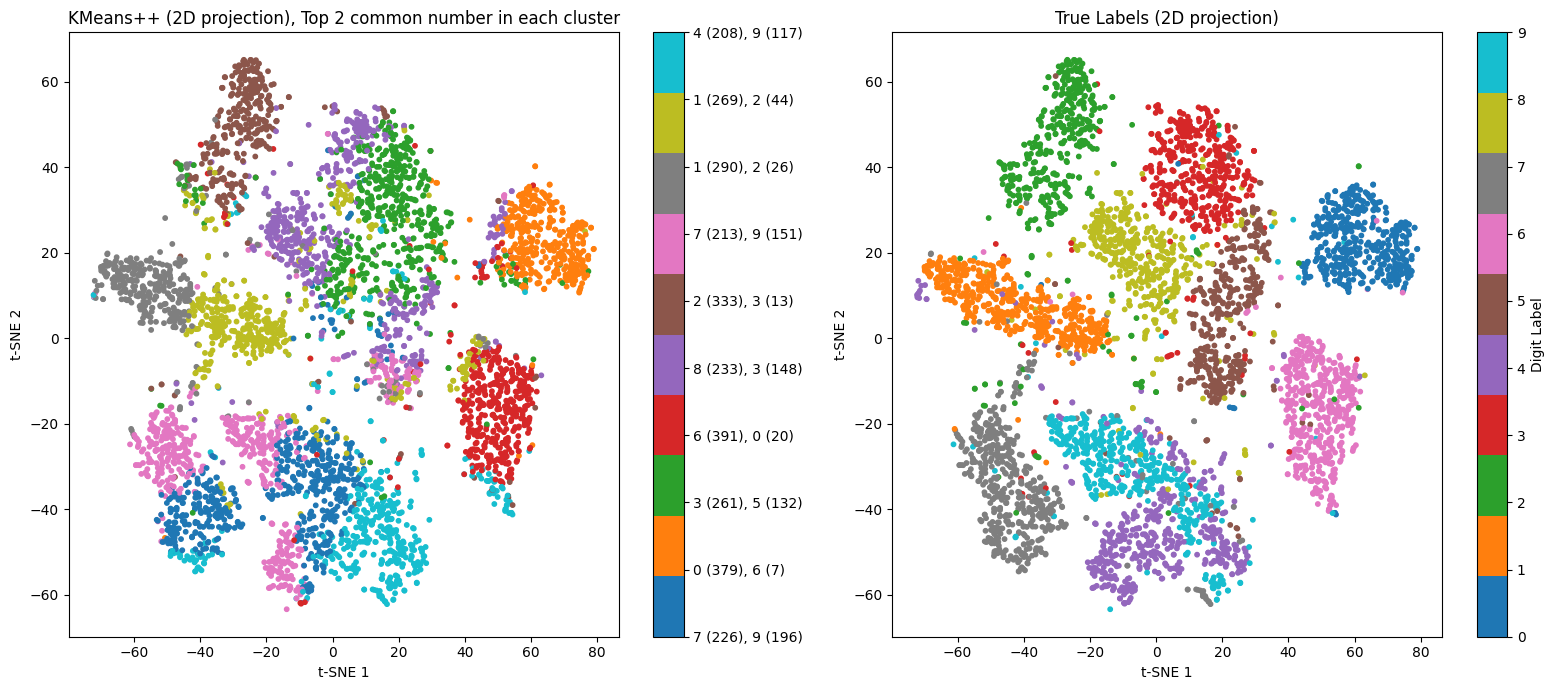

In [8]:
# ----------------------------
# TODO Implement Kmeans ++
# ----------------------------

from sklearn.cluster import KMeans

# Number of clusters (digits 0–9)
k = 10

# Initialize and fit KMeans++
kmeans_pp = KMeans(
    n_clusters=k,
    init="k-means++",   # explicitly using KMeans++
    n_init=10,
    max_iter=50,
    random_state=42
)

kmeans_pp.fit(X)

# Get labels and centroids
labels_pp = kmeans_pp.labels_
centroids_pp = kmeans_pp.cluster_centers_

print("KMeans++ clustering completed.")
print("Labels shape:", labels_pp.shape)
print("Centroids shape:", centroids_pp.shape)


# ----------------------------
# Implemenetation ends here
# ----------------------------

# Reduce to 2D for visualization
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)


tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_pp == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")


fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMeans clusters
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_pp, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMeans++ (2D projection), Top 2 common number in each cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()



# [TODO]: Find Confused Digit Pairs  in Kmeans++ (1 point)

- For each cluster, check the **second most common true label**.  
- If its count is **greater than 50**, record the pair (most common, second most common) and write your answer here.

Answer: [TODO]

Cluster 0: Most=(np.int64(7), 226), Second=(np.int64(9), 196)
Cluster 2: Most=(np.int64(3), 261), Second=(np.int64(5), 132)
Cluster 4: Most=(np.int64(8), 233), Second=(np.int64(3), 148)
Cluster 6: Most=(np.int64(7), 213), Second=(np.int64(9), 151)
Cluster 9: Most=(np.int64(4), 208), Second=(np.int64(9), 117)

Confused digit pairs (most common, second most common):
[(np.int64(7), np.int64(9)), (np.int64(3), np.int64(5)), (np.int64(8), np.int64(3)), (np.int64(7), np.int64(9)), (np.int64(4), np.int64(9))]


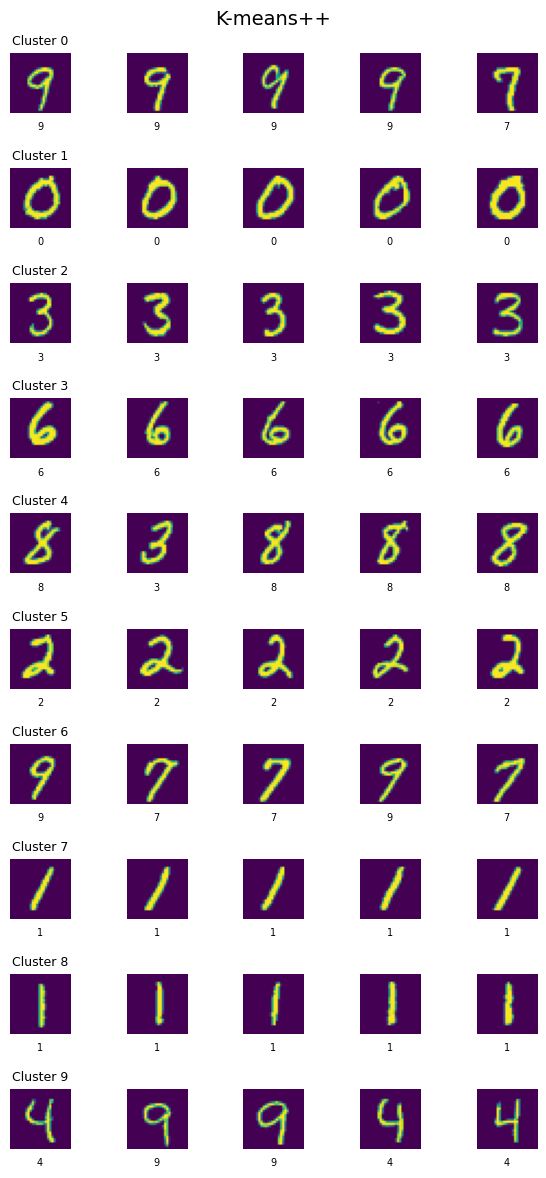

In [9]:
from collections import Counter

confused_pairs_pp = []

for cluster_id in range(k):
    # indices of samples in this cluster
    idxs = np.where(labels_pp == cluster_id)[0]
    true_labels = y[idxs]

    # count occurrences of each digit
    counts = Counter(true_labels).most_common()

    if len(counts) > 1:  # at least 2 labels present
        most_common, second_common = counts[0], counts[1]

        if second_common[1] > 50:  # second most common ≥ 50
            confused_pairs_pp.append((most_common[0], second_common[0]))
            print(f"Cluster {cluster_id}: Most={most_common}, Second={second_common}")

print("\nConfused digit pairs (most common, second most common):")
print(confused_pairs_pp)

show_closest_images(X, dataset, centroids_pp, labels_pp, "K-means++")

# [TODO] Implement Kmedioids (2 points)

## Instructions
KMedoids (with `kmedoids` package)

- Use the `KMedoids` class from the **`kmedoids`** package, which you must have pip installed at the start of the notebook.  
- Set the following parameters:
  - `n_clusters = k` → number of clusters (choose based on dataset).  
  - `method = "fasterpam"` → efficient implementation of the PAM algorithm.  
  - `metric = "precomputed"` → pass a precomputed distance matrix.  
  - `random_state = 42` → ensures reproducibility.  
Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to anotehr value **you will not get full score**.

Extra Note:  Before running KMedoids, you need to compute a **distance matrix** using e.g.  
  ```python
dist_matrix = pairwise_distances(X, metric="manhattan")



KMedoids clustering completed.
Labels shape: (5000,)


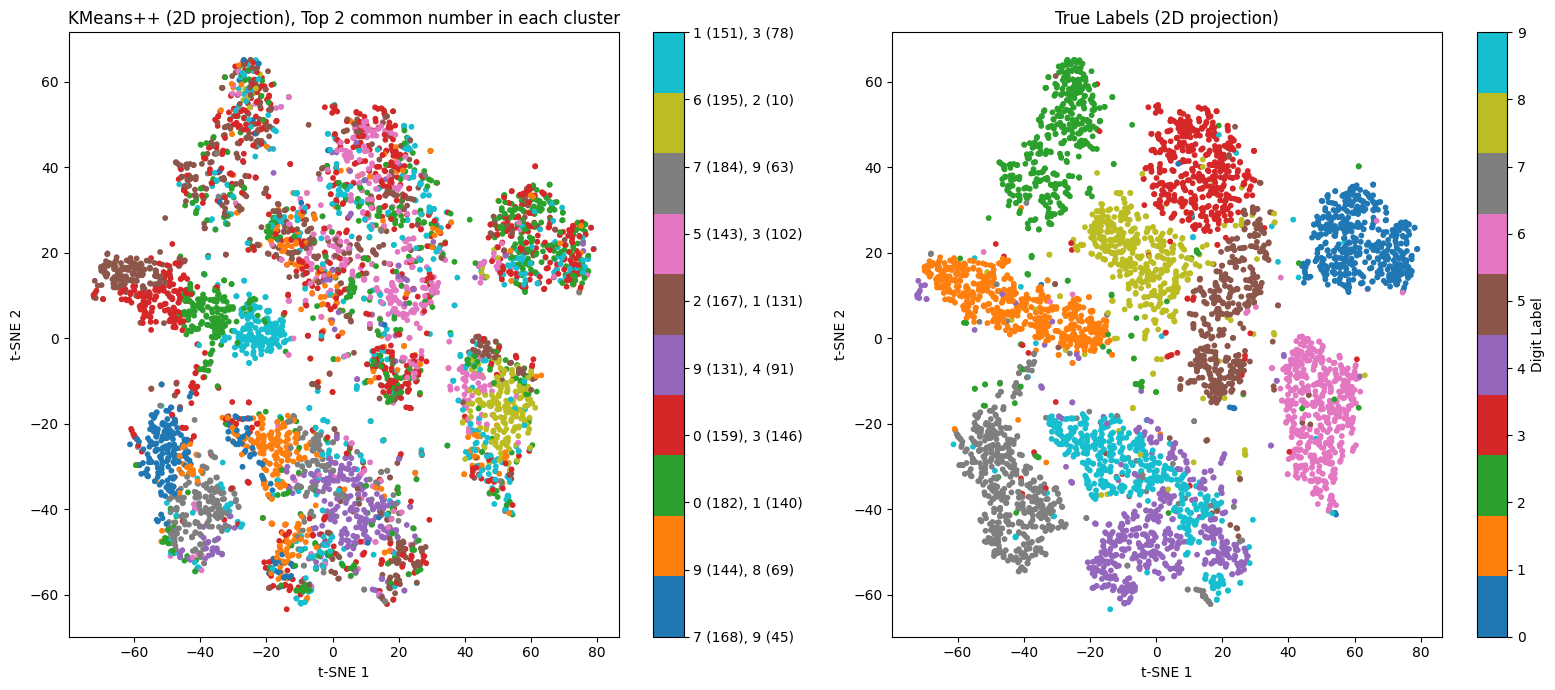

In [12]:
# -------------------------
# TODO Implement KMedoids
# ------------------------

from sklearn.metrics import pairwise_distances

# Number of clusters
k = 10

# Compute distance matrix (Manhattan distance)
dist_matrix = pairwise_distances(X, metric="manhattan")

# Initialize and fit KMedoids
kmed = kmedoids.KMedoids(
    n_clusters=k,
    method="fasterpam",
    metric="precomputed",
    random_state=42
)

kmed.fit(dist_matrix)

# Get labels
labels_kmed = kmed.labels_

print("KMedoids clustering completed.")
print("Labels shape:", labels_kmed.shape)




# ----------------------------
# Implementation ends here
# ----------------------------

# Reduce to 2D for visualization
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)


tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_kmed == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")


fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMeans clusters
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmed, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMeans++ (2D projection), Top 2 common number in each cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()




# [TODO] Find Confused Digit Pairs  in Kmedioids (1 point)

- For each cluster, check the **second most common true label**.  
- If its count is **greater than 50**, record the pair (most common, second most common) and write your answer here.

Answer: [TODO]

In [13]:
from collections import Counter

confused_pairs_kmed = []

for cluster_id in range(k):
    # indices of samples in this cluster
    idxs = np.where(labels_kmed == cluster_id)[0]
    true_labels = y[idxs]

    # count occurrences of each digit
    counts = Counter(true_labels).most_common()

    if len(counts) > 1:  # need at least 2 labels
        most_common, second_common = counts[0], counts[1]

        if second_common[1] > 50:  # only consider if ≥ 50 samples
            confused_pairs_kmed.append((most_common[0], second_common[0]))
            print(f"Cluster {cluster_id}: Most={most_common}, Second={second_common}")

print("\nConfused digit pairs (most common, second most common):")
print(confused_pairs_kmed)


Cluster 1: Most=(np.int64(9), 144), Second=(np.int64(8), 69)
Cluster 2: Most=(np.int64(0), 182), Second=(np.int64(1), 140)
Cluster 3: Most=(np.int64(0), 159), Second=(np.int64(3), 146)
Cluster 4: Most=(np.int64(9), 131), Second=(np.int64(4), 91)
Cluster 5: Most=(np.int64(2), 167), Second=(np.int64(1), 131)
Cluster 6: Most=(np.int64(5), 143), Second=(np.int64(3), 102)
Cluster 7: Most=(np.int64(7), 184), Second=(np.int64(9), 63)
Cluster 9: Most=(np.int64(1), 151), Second=(np.int64(3), 78)

Confused digit pairs (most common, second most common):
[(np.int64(9), np.int64(8)), (np.int64(0), np.int64(1)), (np.int64(0), np.int64(3)), (np.int64(9), np.int64(4)), (np.int64(2), np.int64(1)), (np.int64(5), np.int64(3)), (np.int64(7), np.int64(9)), (np.int64(1), np.int64(3))]


# [TODO] Compute Silhouette scores for MNIST (2 points)

In [14]:

# -------------------------------------------------------------------------------------
# TODO Implement Metrics: Compute Silhouette scores for Kmeans, Kmeans++ and Kmedioids
# --------------------------------------------------------------------------------------

from sklearn.metrics import silhouette_score

# Compute silhouette scores
sil_km_rand = silhouette_score(X, labels_km, metric="euclidean")
sil_km_pp   = silhouette_score(X, labels_pp, metric="euclidean")
sil_kmed    = silhouette_score(X, labels_kmed, metric="euclidean")

print("Silhouette Score (KMeans):", sil_km_rand)
print("Silhouette Score (KMeans++):", sil_km_pp)
print("Silhouette Score (KMedoids):", sil_kmed)


# ----------------------------
# Implemenetation ends here
# ----------------------------

results = pd.DataFrame({
    "Algorithm": ["KMeans", "KMeans++", "KMedoids"],
    "Silhouette Score": [sil_km_rand, sil_km_pp, sil_kmed]
})
results



Silhouette Score (KMeans): 0.069798656
Silhouette Score (KMeans++): 0.069798656
Silhouette Score (KMedoids): -0.00555128


Algorithm  Silhouette Score
0    KMeans          0.069799
1  KMeans++          0.069799
2  KMedoids         -0.005551

# [TODO] Using the Silhouette scores answer which method is doing better? (1 point)


Answer: Based on the silhouette scores, both KMeans and KMeans++ perform better than KMedoids, with nearly identical scores (~0.07). KMedoids performs poorly, even giving a slightly negative score, which indicates worse clustering.


# Clustering a pixels in a Single Image

## [TODO] Image Clustering with KMeans and KMeans++ (2 points)

In this exercise, you will explore how clustering can be applied to images.  
Instead of clustering entire datasets, we cluster the **pixels** of an image based on their RGB values.  

Instructions for Kmeans:

- Use the `KMeans` class from `sklearn.cluster`.
- Set the following parameters:
  - `n_clusters = k` (set this to 5).  
  - `init = "?"` what should this be for Kmeans?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).  

Instructions for Kmeans ++

- Use the `KMeans` class from `sklearn.cluster`.
- Set the following parameters:
  - `n_clusters = k` (choose based on the dataset what do you think thge right number is for this dataset?).  
  - `init = "?"` what should this be for Kmeans ++ ?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to another value **you will not get full score**.

In [16]:
!git clone https://github.com/CS506-Boston-University/lab3-Saneeya1402.git
%cd lab3-Saneeya1402


Cloning into 'lab3-Saneeya1402'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 11 (delta 1), reused 1 (delta 1), pack-reused 8 (from 2)
Receiving objects: 100% (11/11), 5.04 MiB | 47.39 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/lab3-Saneeya1402


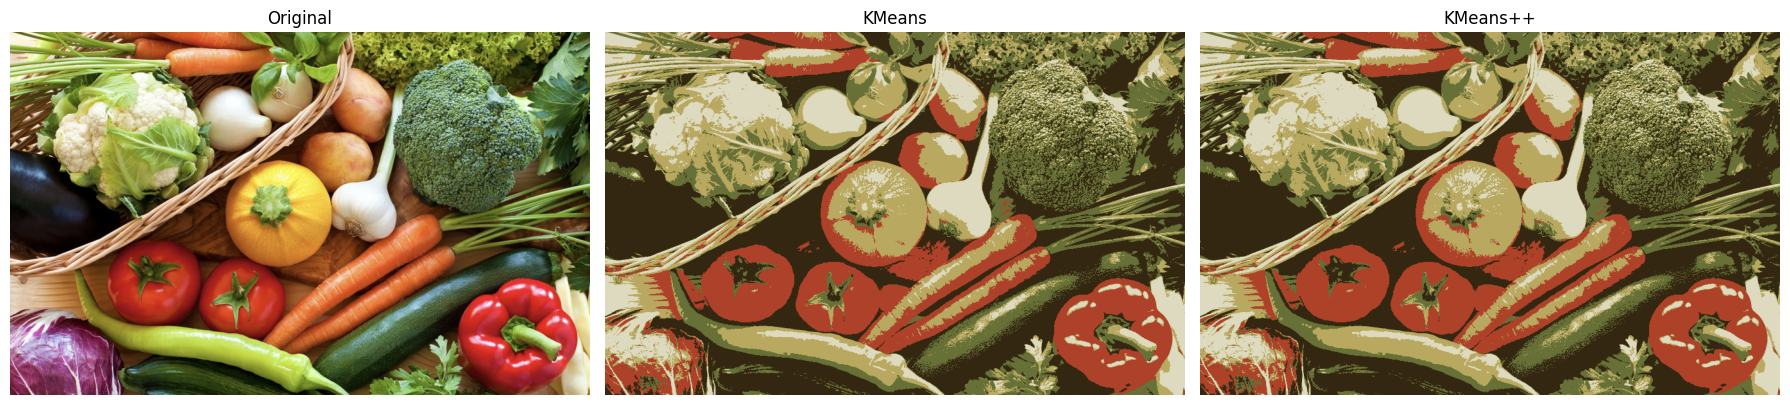

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from skimage.io import imread
from skimage.transform import rescale
import kmedoids


image = imread("image0.png")
image = rescale(image, 0.5, channel_axis=-1)

image_shape = image.shape
pixels = image.reshape(-1, image_shape[-1])

# ------------------------------------------------------------
# TODO Implement KMeans
# ------------------------------------------------------------

kmeans_rand = KMeans(
    n_clusters=5,
    init="random",
    n_init=10,
    max_iter=50,
    random_state=42
)
labels_rand = kmeans_rand.fit_predict(pixels)
new_colors_rand = kmeans_rand.cluster_centers_[labels_rand]

# If colors are in [0,1], rescale to [0,255]
if new_colors_rand.max() <= 1.0:
    new_colors_rand = (new_colors_rand * 255)

quantized_rand = new_colors_rand.reshape(image_shape).astype(np.uint8)

# ------------------------------------------------------------
# TODO KMeans++
# ------------------------------------------------------------

kmeans_pp = KMeans(
    n_clusters=5,
    init="k-means++",
    n_init=10,
    max_iter=50,
    random_state=42
)
labels_pp = kmeans_pp.fit_predict(pixels)
new_colors_pp = kmeans_pp.cluster_centers_[labels_pp]

if new_colors_pp.max() <= 1.0:
    new_colors_pp = (new_colors_pp * 255)

quantized_pp = new_colors_pp.reshape(image_shape).astype(np.uint8)

# ------------------------------------------------------------
# Implementation Ends here
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(quantized_rand)
axes[1].set_title("KMeans")
axes[1].axis("off")

axes[2].imshow(quantized_pp)
axes[2].set_title("KMeans++")
axes[2].axis("off")


plt.tight_layout()
plt.show()





## [TODO] Image Clustering (Instructions) (10 points)
1. Load each of the three images which should be given to you (image1.jpg, image2.jpg, image3.jpg)
2. For each image, apply **KMeans clustering** twice:  
   - **KMeans (Random Init)**  
   - **KMeans++ (Smart Init)**  
3. Replace each pixel with the color of its cluster centroid.  
   - This reduces the number of unique colors in the image.  
   - The result is a “posterized” image with simplified colors.  
4. Display the results in a **3×3 grid**:  
   - **Column 1** → Original images.  
   - **Column 2** → KMeans results.  
   - **Column 3** → KMeans++ results.  

You need to get the output as follows:
- A single figure with 9 panels (3 rows × 3 columns).  
- Each row corresponds to one image.  
- The leftmost image in each row is the original, followed by its KMeans and KMeans++ clustered versions.  
---


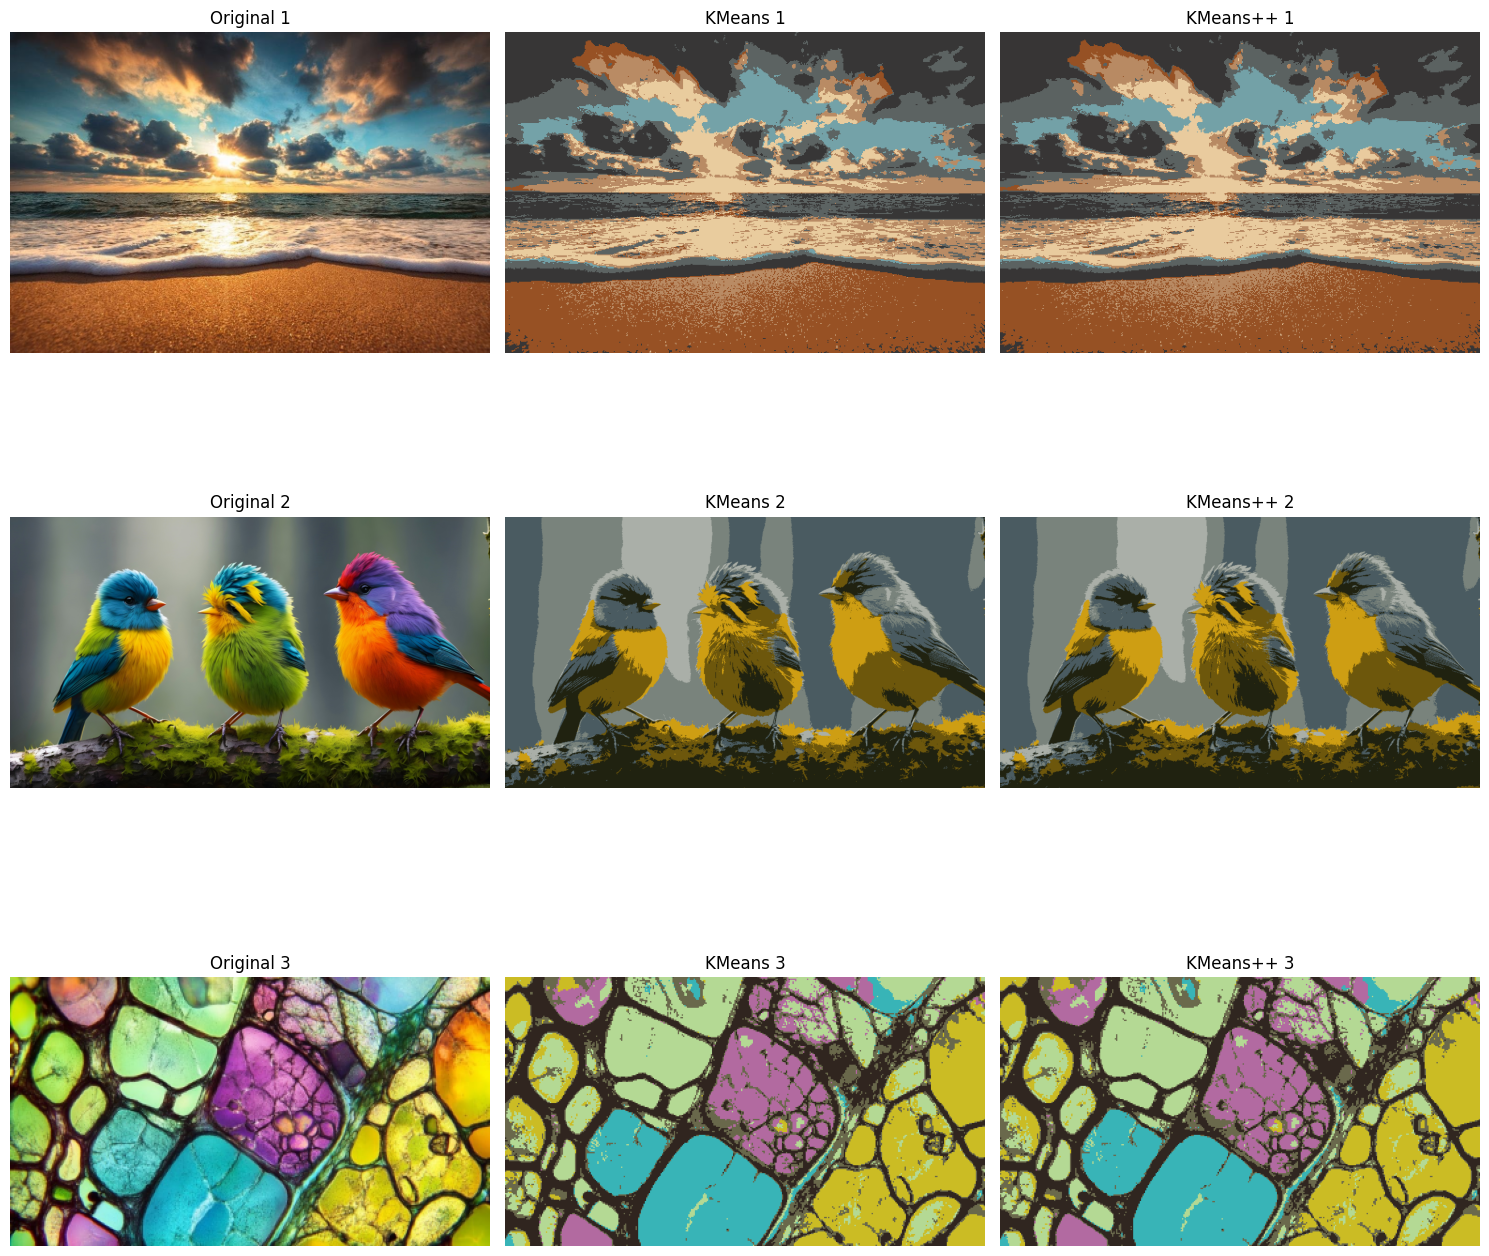

In [22]:


def cluster_image(image_path, k=5):
    image = imread(image_path)
    image = rescale(image, 0.5, channel_axis=-1)
    h, w, c = image.shape
    pixels = image.reshape(-1, c)


    # ----------------------------------------------
    # Implement Kmeans
    # ----------------------------------------------

    kmeans_rand = KMeans(
    n_clusters=k,
    init="random",
    n_init=10,
    max_iter=50,
    random_state=42
    )
    labels_rand = kmeans_rand.fit_predict(pixels)
    new_colors_rand = kmeans_rand.cluster_centers_[labels_rand]

    # Rescale if necessary
    if new_colors_rand.max() <= 1.0:
        new_colors_rand = (new_colors_rand * 255)

    kmeans_image = new_colors_rand.reshape(h, w, c).astype(np.uint8)



    # ----------------------------------------------
    # Implement Kmeans ++
    # ----------------------------------------------

    kmeans_pp = KMeans(
    n_clusters=k,
    init="k-means++",
    n_init=10,
    max_iter=50,
    random_state=42
    )
    labels_pp = kmeans_pp.fit_predict(pixels)
    new_colors_pp = kmeans_pp.cluster_centers_[labels_pp]

    if new_colors_pp.max() <= 1.0:
        new_colors_pp = (new_colors_pp * 255)

    kmeans_pp_image = new_colors_pp.reshape(h, w, c).astype(np.uint8)

    # ----------------------------------------------
    # Implementation ends here
    # ----------------------------------------------

    return image, kmeans_image, kmeans_pp_image


images = ["image1.jpg", "image2.jpg", "image3.jpg"]
results = [cluster_image(img, k=6) for img in images]


fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, (orig, km_rand, km_pp) in enumerate(results):
    axes[i, 0].imshow(orig)
    axes[i, 0].set_title(f"Original {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(km_rand)
    axes[i, 1].set_title(f"KMeans {i+1}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(km_pp)
    axes[i, 2].set_title(f"KMeans++ {i+1}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()



# [TODO] Answer the following questions (8 points)

---

**1. Question:** What does the Silhouette Score of KMeans++ for MNIST dataset represent?  

**Answer:**  The Silhouette Score computes how well the data points fit within their clusters compared to other clusters. The larger the score, the denser and more well-separated the clusters, and the smaller or even negative the score, the more the clusters overlap or are poorly formed. For MNIST, it's telling us how well KMeans++ grouped the digit images by similarity.

---

**2. Question:** When you used the KMeans library you set `n_init = 10`. What does `n_init` do?  

**Answer:**  n_init controls how many times the KMeans algorithm is run with different random initializations of the cluster centers. The best result (lowest inertia) of these runs is kept. Putting n_init = 10 makes the clustering more stable and less prone to bad random initializations.

---

**3. Question:** When you used the KMeans library you set `max_iter = 50`. What does `max_iter` do?  

**Answer:**  max_iter is the maximum number of iterations the algorithm will perform to refine cluster centers in a single run. If convergence is reached sooner, the algorithm will stop before this number; otherwise, it will stop after 50 iterations.


---

**4. Question:** What distance metric did you use for computing the Silhouette score of KMedoids?  

**Answer:**  The Manhattan distance (L1 distance) was the distance metric used, as provided in the pairwise_distances(X, metric="manhattan") step before running KMedoids.


---
